# Building a basic knowledge graph using NLP tools

In this notebook, we show how to use a combination of NLP tools to build a knowledge graph from a text in Danish. 

The idea is to pick a text (in this example, a paragraph from a Wikipedia page), extract relevant information from it (e.g. entities, actions) and link it together in order to produce a readable graph which quickly conveys shallow events from the text. 

In practice, we show : 
* how to apply core NLP tools such as **named entity recognition**, **part-of-speech tagging**, **dependency parsing** and more advanced, such as **coreference resolution** 
* how to use and combine the output of these models to build a basic **knowledge graph**


In [1]:
# import the libraries needed for running the notebook
import requests
from danlp.models import load_spacy_model, load_xlmr_coref_model
import networkx as nx
import matplotlib.pyplot as plt

## 1. Get some text from Wikipedia

In this step, we collect some text from a selected Wikipedia page. 
If you wish to try the method on your own text, skip the two following cells and insert a line to indicate which is your text: 

`text = 'your text'`. 

In [2]:
# select the subject of your choice
# examples : 
# subject = 'Viggo_Mortensen'
# subject = 'Mads_Mikkelsen'
subject = 'Mette_Frederiksen'

# submit a request to Wikipedia API
response = requests.get('https://dk.wikipedia.org/w/api.php', 
                    params={'action': 'query',
                    'format': 'json',
                    'titles': subject,
                    'prop': 'extracts',
                    'exintro': True,
                    'explaintext': True,
                    }).json()

In [3]:
# get the intro paragraph
text = list(response['query']['pages'].values())[0]['extract']
text = text.replace('\n', ' ')

In [4]:
text

'Mette Frederiksen (født 19. november 1977 i Aalborg) er en dansk socialdemokratisk politiker, der siden 27. juni 2019 er Danmarks statsminister. Desuden har hun siden 28. juni 2015 været formand for Socialdemokratiet. Hun har været medlem af Folketinget siden den 20. november 2001. Den 20. juni 2015 blev hun konstitueret formand for Socialdemokratiet, indtil hun blev valgt af partiet som formand den 28. juni samme år, efter at Helle Thorning-Schmidt havde meddelt sin afgang på valgnatten efter folketingsvalget den 18. juni 2015. Mette Frederiksen har tidligere beklædt flere ordførerposter; i 2005 blev hun socialordfører og var fra 2005-2011 næstformand i folketingsgruppen. Fra 3. oktober 2011 til 10. oktober 2014 var hun beskæftigelsesminister i regeringen Helle Thorning-Schmidt I. Den 10. oktober 2014 tiltrådte hun posten som Justitsminister, efter at Karen Hækkerup havde meldt sin afgang, fordi hun havde fået jobbet som administrerende direktør i Landbrug & Fødevarer. Ved folketings

## 2. Segment the text into sentences and tokens

We use the spaCy model for segmenting the text into sentences and segmenting each sentence into tokens.

In [5]:
# load the spacy model
nlp = load_spacy_model()

In [6]:
# parse the text
doc = nlp(text)
# get the tokenized sentences and tokens
sentences = [[t.text for t in sent] for sent in doc.sents]
tokens = [t.text for t in doc]

## 3. Build a basic knowledge graph from dependencies

The Spacy model applied to the sentences also provides syntactical dependencies extracted from the text. 
We use this information to build a first knowledge graph (KG).

For more details about dependency parsing see [our documentation](https://danlp-alexandra.readthedocs.io/en/latest/docs/tasks/dependency.html).

In the following, we define the nodes ans edges of our KG. 

Nodes are subject and objects of verbs.
For a subject `s`, an object `o` and a verb `v`, if it exists dependencies such as `s <- v` and `v -> o`, then we define an edge as a triplet: `(s,v,o)`. 


In [7]:
# get the verb phrase from the root token
def get_verb_phrase(token):
    rchil = []
    lchil = []
    for t in token.children:
        if t.dep_ in ["aux"]:
            if t.i<token.i:
                rchil.append(t.text)
            else:
                lchil.append(t.text)
    return " ".join(rchil) + " " + token.text + " " + " ".join(lchil)

In [8]:
# Using pos-tags and dependencies to define nodes and edges of a knowledge graph

nodes = {}
functions = {}
edges = []

for token in doc:
    # we only consider VERBs as relevant relations between the entities
    if token.tag_ == "VERB":
        subj = None
        objs = []
        obls = []
        # we look for the children of the verb that are subjects and objects
        for c in token.children:
            if not c.tag_ in ['NOUN', 'PROPN', 'PRON']:
                continue
            if c.dep_ == 'nsubj':
                subj = c
            elif c.dep_ in ['obj','obl']:
                objs.append(c)
        if subj:
            subj_text = subj.text
            # the subject is a node
            nodes[subj.i] = subj_text
            verb_text = get_verb_phrase(token)
            functions[token.i] = verb_text
            for o in objs:
                obj_text = o.text
                # the object is a node
                nodes[o.i] = obj_text
                print(subj_text, '\t--', verb_text, '-->\t', '\t', obj_text, o.tag_, o.dep_)
                # an edge is defined as a relation (verb) between a subject and an object
                edges.append((subj.i, token.i, o.i))
        

Mette 	--  født  -->	 	 november NOUN obj
hun 	-- blev konstitueret  -->	 	 juni NOUN obl
hun 	-- blev konstitueret  -->	 	 formand NOUN obj
hun 	-- blev valgt  -->	 	 partiet NOUN obl
hun 	-- blev valgt  -->	 	 juni NOUN obl
Helle 	-- havde meddelt  -->	 	 afgang NOUN obj
Helle 	-- havde meddelt  -->	 	 valgnatten NOUN obl
Helle 	-- havde meddelt  -->	 	 folketingsvalget NOUN obl
Mette 	-- har beklædt  -->	 	 ordførerposter NOUN obl
hun 	--  tiltrådte  -->	 	 oktober NOUN obl
hun 	--  tiltrådte  -->	 	 posten NOUN obj
hun 	--  tiltrådte  -->	 	 Justitsminister NOUN obl
Karen 	-- havde meldt  -->	 	 afgang NOUN obj
hun 	-- havde fået  -->	 	 jobbet NOUN obj
hun 	-- havde fået  -->	 	 direktør NOUN obl
Mette 	--  opnåede  -->	 	 folketingsvalget NOUN obl
Mette 	--  opnåede  -->	 	 stemmetal NOUN obj
hvilket 	--  placerede  -->	 	 hende PRON obj
hvilket 	--  placerede  -->	 	 nummer NOUN obl
hun 	--  åbnede  -->	 	 debatten NOUN obj
hun 	--  åbnede  -->	 	 forbud NOUN obl
hun 	--  stod  

In [9]:
# building the graph
G = nx.DiGraph()

G.add_nodes_from(list(nodes.keys()))
G.add_edges_from([(s,o) for (s,_,o) in edges])

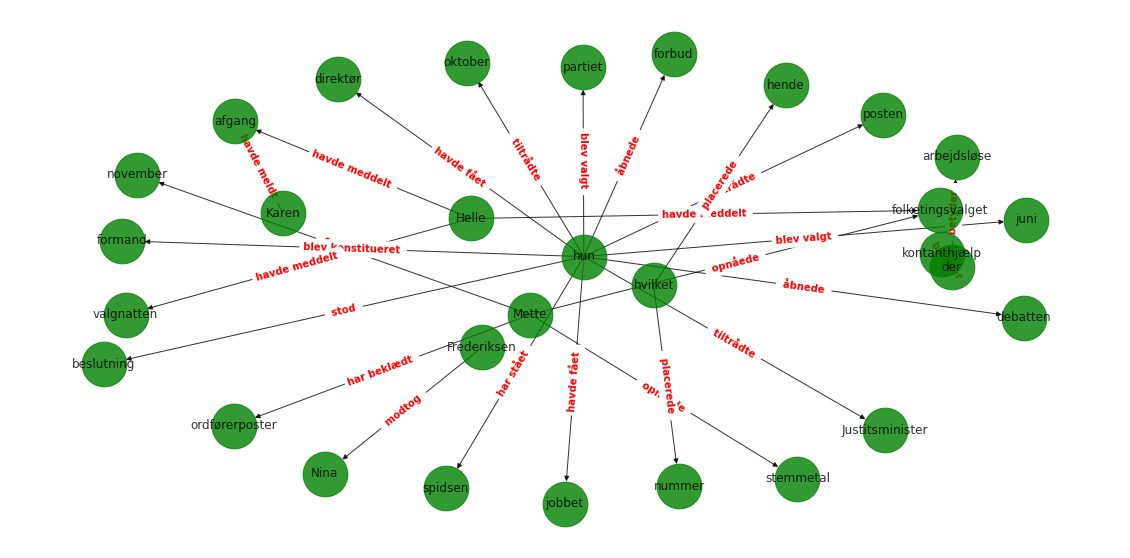

In [10]:
# visualising the graph
fig, ax = plt.subplots(figsize=(20, 10))
H = nx.relabel_nodes(G, nodes)
pos = nx.spring_layout(H, k=1, iterations=100)
nx.draw(H, pos, with_labels=True, node_size=2000,node_color='green', alpha=0.8)
edge_labels = {(nodes[s], nodes[o]):functions[l] for (s,l,o) in edges}
nx.draw_networkx_edge_labels(H, pos, font_size=10, edge_labels=edge_labels, arrowstyle='fancy', font_color='red', font_weight="bold", width=3)
plt.axis('off')
plt.show()

## 4. Enrich the nodes

In the KG previously built, we notice that nodes are composed of single tokens. Instead of single tokens, we would like to enrich a node description with the span that corresponds to the complete entity or phrase in the original text (such `Mette Frederiksen` instead of `Frederiksen`).

Using the output of spaCy as well, we extract enriched information for the nodes of our graph, in particular: 
* named entities (using [NER](https://danlp-alexandra.readthedocs.io/en/latest/docs/tasks/ner.html))
* noun phrases (using [POS-tagging](https://danlp-alexandra.readthedocs.io/en/latest/docs/tasks/pos.html) and [dependency parsing](https://danlp-alexandra.readthedocs.io/en/latest/docs/tasks/dependency.html) -- [chunking](https://danlp-alexandra.readthedocs.io/en/latest/docs/tasks/dependency.html#noun-phrase-chunking) could also be used as an alternative)

Named entities are person, organization or location names. 
Phrases are groups of tokens (usually following each other in the text). Here we focus on extracted nominal phrases (for which the core token is a noun and adjacent tokens can be adjectives, numbers...). 


In [11]:
# Using NER to find entities

tok_id2entity_id = {}
entities = {}

for ent in doc.ents:
    if ent.label_ == 'MISC':
        continue
    ent_id = len(entities)+1
    entities[ent_id] = ent.text
    for i in range(ent.start, ent.end):
        tok_id2entity_id[i] = ent_id 

for e in entities.values():
    print(e)

Mette Frederiksen
Aalborg
Danmarks
Socialdemokratiet
Folketinget
Socialdemokratiet
Helle Thorning-Schmidt
Mette Frederiksen
Helle Thorning-Schmidt
Justitsminister
Karen Hækkerup
Landbrug & Fødevarer
Mette Frederiksen
Frederiksen
Nina Bang-prisen
2012 Ting-Prisen
Epostler


In [12]:
# basic phrase extraction using pos-tags and dependencies
tok_id2phrase_id = {}
phrases = {}

for tok in doc:
    if tok.tag_ == 'NOUN':
        # collect neighboring children tokens
        phrase = [t for t in tok.subtree if tok.i-1 <= t.i <= tok.i+1 and t.tag_ in ['ADJ', 'NOUN', 'NUM', 'PROPN',]]
        text_phrase = " ".join([t.text for t in phrase])
        print(text_phrase)
        
        phr_id = len(phrases)+1
        phrases[phr_id] = text_phrase
        for t in phrase:
            tok_id2phrase_id[t.i] = phr_id


19. november 1977
socialdemokratisk politiker
27. juni 2019
Danmarks statsminister
28. juni 2015
formand
Socialdemokratiet
medlem
Folketinget
20. november 2001
20. juni 2015
formand
Socialdemokratiet
partiet
formand
28. juni samme
samme år
afgang
valgnatten
folketingsvalget
18. juni 2015
flere ordførerposter
socialordfører
2005-2011 næstformand
folketingsgruppen
3. oktober 2011
10. oktober 2014
beskæftigelsesminister
regeringen Helle
10. oktober 2014
posten
Justitsminister
afgang
jobbet
direktør
Fødevarer
folketingsvalget
personligt stemmetal
27.077 stemmer
nummer syv
ti-listen
danske politikere
personlige stemmer
debatten
forbud
prostitution
kongressens
kongressens beslutning
Socialdemokraterne
arbejde
forbud
køb
ydelser".Som
beskæftigelsesminister
spidsen
reformer
førtidspension
fleksjob
beskæftigelsessystemet
kontanthjælpsreform
lavere kontanthjælp
unge arbejdsløse
gensidig forsørgelsespligt
Bang-prisen
virkelyst
gennemslagskraft
social fornemmelse
medforfatter
bøgerne Epostler
Epos

In [13]:
# Chunking is an alternative for finding noun phrases

#from danlp.models import load_spacy_chunking_model
#chunker = load_spacy_chunking_model(nlp)
#np_chunks = chunker.predict(text, bio=False)
#for (s,e, _) in np_chunks:
#    print(" ".join([tokens[i] for i in range(s,e)]))

In [14]:
# an entity (or a keyphrase) is often a span over multiple tokens
# from the id of one of the tokens, we return the entire text span
def get_full_span(idx, original_text):
    if idx in tok_id2entity_id:
        return entities[tok_id2entity_id[idx]]
    elif idx in tok_id2phrase_id:
        return phrases[tok_id2phrase_id[idx]]
    else:
        return original_text

In [15]:
# replace the text of each node by the complete entity or phrase when it exists

for node_id, single_token_text in nodes.items():
    nodes[node_id] = get_full_span(node_id, single_token_text)

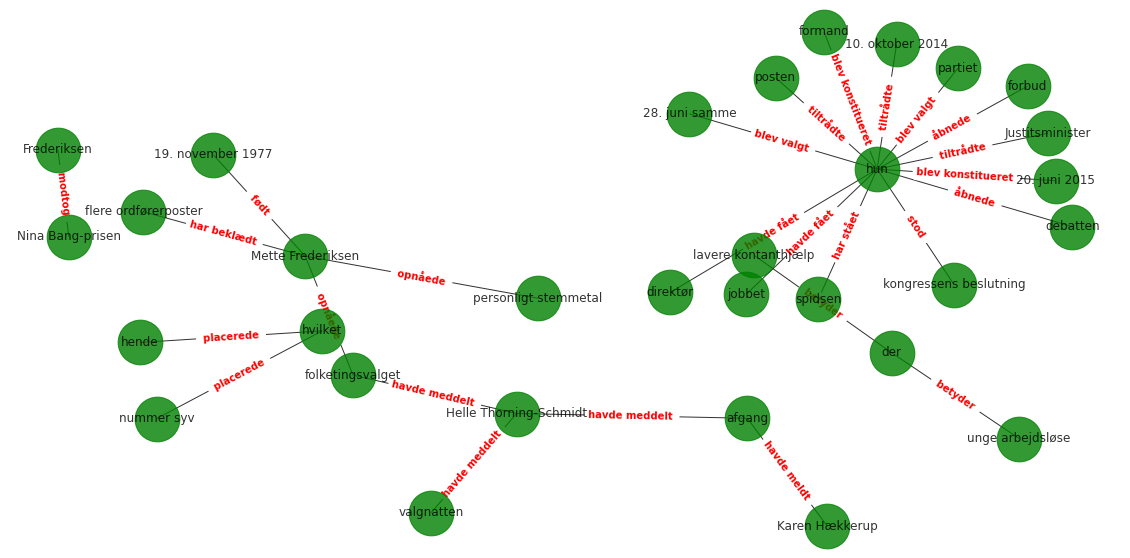

In [16]:
# building the graph
G = nx.Graph()

G.add_nodes_from(list(nodes.keys()))
G.add_edges_from([(s,o) for (s,_,o) in edges])

# visualising the graph
fig, ax = plt.subplots(figsize=(20, 10))
H = nx.relabel_nodes(G, nodes)
pos = nx.spring_layout(H, k=1, iterations=100)
nx.draw(H, pos, with_labels=True, node_size=2000,node_color='green', alpha=0.8)
edge_labels = {(nodes[s], nodes[o]):functions[l] for (s,l,o) in edges}
nx.draw_networkx_edge_labels(H, pos, font_size=10, edge_labels=edge_labels, font_color='red', font_weight="bold", width=3)
plt.axis('off')
plt.show()

## 5. Connect the entities using coreference resolution

In the previous graph, we can see that some references (`Mette Frederiksen`, `hun`) that refers to the same entity are considered as independant entities.
We now use coreference resolution to find which references refer to the same entity and merge them in the resulting KG. 

See our documentation on [coreference resolution](https://danlp-alexandra.readthedocs.io/en/latest/docs/tasks/coreference.html) for more details.

In [17]:
# loading the model
coref_model = load_xlmr_coref_model()

Use coarse to fine: True


In [18]:
# applying the coreference resolution model on the tokenized sentences
preds = coref_model.predict(sentences)

In [19]:
clusters = preds['clusters']

In [20]:
# printing the top spans

for span in preds['top_spans']:
    ref = tokens[span[0]:span[1]]
    if len(ref)>0:
        print(ref)

['Mette']
['Mette', 'Frederiksen', '(', 'født', '19.', 'november', '1977', 'i', 'Aalborg']
['Mette', 'Frederiksen', '(', 'født', '19.', 'november', '1977', 'i', 'Aalborg', ')', 'er', 'en', 'dansk', 'socialdemokratisk']
['en', 'dansk', 'socialdemokratisk']
['Danmarks']
['har', 'hun', 'siden', '28.', 'juni', '2015', 'været', 'formand', 'for']
['28.', 'juni', '2015', 'været', 'formand', 'for']
['formand', 'for']
['den', '20.', 'november']
['hun', 'konstitueret', 'formand', 'for']
['formand', 'for']
['Helle']
['sin', 'afgang', 'på', 'valgnatten', 'efter', 'folketingsvalget', 'den', '18.', 'juni']
['valgnatten', 'efter', 'folketingsvalget', 'den', '18.', 'juni']
['folketingsvalget', 'den', '18.', 'juni']
['Mette']
['flere']
['2005', 'blev', 'hun', 'socialordfører', 'og', 'var', 'fra', '2005-2011', 'næstformand', 'i']
['blev', 'hun']
['blev', 'hun', 'socialordfører', 'og', 'var', 'fra', '2005-2011', 'næstformand', 'i']
['3.', 'oktober']
['10.', 'oktober']
['10.', 'oktober', '2014', 'var', 'h

In [21]:
# printing the clusters 

for clust_id, cluster in enumerate(clusters):
    print("[ Cluster", clust_id, "]")
    for ref_idx in cluster:
        ref = tokens[ref_idx[0]:ref_idx[1]+1]
        if len(ref)>0:
            print("token id = ",ref_idx[0], "\t\t", " ".join(ref))
    print()

[ Cluster 0 ]
token id =  0 		 Mette Frederiksen
token id =  16 		 der
token id =  27 		 hun
token id =  37 		 Hun
token id =  54 		 hun
token id =  61 		 hun
token id =  91 		 Mette Frederiksen
token id =  102 		 hun
token id =  121 		 hun
token id =  133 		 hun
token id =  165 		 Mette Frederiksen
token id =  176 		 hende
token id =  194 		 hun
token id =  204 		 hun
token id =  225 		 hun
token id =  259 		 Frederiksen
token id =  285 		 Hun

[ Cluster 1 ]
token id =  35 		 Socialdemokratiet
token id =  58 		 Socialdemokratiet
token id =  65 		 partiet
token id =  211 		 Socialdemokraterne

[ Cluster 2 ]
token id =  76 		 Helle Thorning-Schmidt
token id =  80 		 sin

[ Cluster 3 ]
token id =  140 		 Karen Hækkerup
token id =  144 		 sin
token id =  148 		 hun

[ Cluster 4 ]
token id =  85 		 folketingsvalget
token id =  161 		 folketingsvalget

[ Cluster 5 ]
token id =  164 		 opnåede Mette Frederiksen et personligt stemmetal på 27.077 stemmer
token id =  174 		 hvilket

[ Cluster 6

In [22]:
# merging the nodes of the KG that refer to the same entity

coref_nodes = {}
coref_edges = []

tok_id2clust_id = {}
for cid, cluster in enumerate(clusters):

    ids = []
    # finding the name of the cluster 
    # (an entity) among the references 
    clust_name = None
    for ref_idx in cluster:
        if clust_name == None and doc[ref_idx[0]].ent_type_ != "":
            clust_name = " ".join(tokens[ref_idx[0]:ref_idx[1]+1])
        ids += range(ref_idx[0], ref_idx[1]+1)
    # when the cluster refers to an entity
    # we create a node
    if clust_name is None:
        continue
    coref_nodes[cid] = clust_name
    
    for i in ids:
        tok_id2clust_id[i] = cid

# we create the new edges based on the previous ones
# merging the nodes
for (s,l,o) in edges: 

    if s in tok_id2clust_id:
        c_s = tok_id2clust_id[s]
    else:
        c_s = len(coref_nodes)+1
        coref_nodes[c_s] = nodes[s]

    if o in tok_id2clust_id:
        c_o = tok_id2clust_id[o]
    else:
        c_o = len(coref_nodes)+1
        coref_nodes[c_o] = nodes[o]

    coref_edges.append((c_s, l, c_o))

In [23]:
# optional
# removing edges that do not link an entity

coref_edges = [(s,l,o) for (s,l,o) in coref_edges if s in tok_id2entity_id or o in tok_id2entity_id]
linked_nodes = [s for (s,_,_) in coref_edges] + [o for (_,_,o) in coref_edges]
coref_nodes = {i:t for (i,t) in coref_nodes.items() if i in linked_nodes}

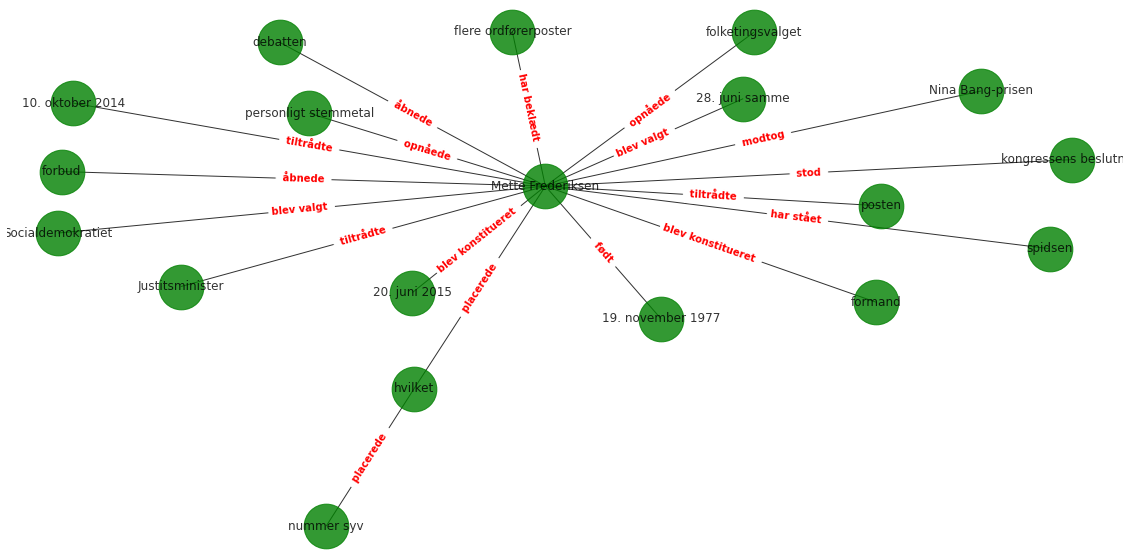

In [24]:
# building the graph
G = nx.Graph()

G.add_nodes_from(list(coref_nodes.keys()))
G.add_edges_from([(s,o) for (s,_,o) in coref_edges])

# visualising the graph
fig, ax = plt.subplots(figsize=(20, 10))
H = nx.relabel_nodes(G, coref_nodes)
pos = nx.spring_layout(H, k=1, iterations=100)
nx.draw(H, pos, with_labels=True, node_size=2000,node_color='green', alpha=0.8)
edge_labels = {(coref_nodes[s], coref_nodes[o]):functions[l] for (s,l,o) in coref_edges}
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red', font_weight="bold", width=3)
plt.axis('off')
plt.show()

### Final note

We built a knowledge graph from a short paragraph in Danish using standard tools available for Danish NLP, combining the output of these models into a meaningul representation using very simple algorithms. 
With more thorough algorithms, focusing for example on specific syntactic depencies or type of entities it would be possible to build a graph that is more accurate and adapted to your needs without much more efforts. 